## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(font_scale = 1.5)

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

### Exploration

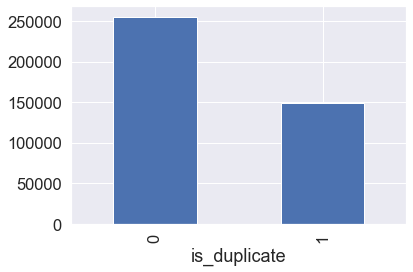

In [4]:
df.groupby('is_duplicate')['id'].count().plot.bar();

In [7]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Total number of question pairs for training:
   404290
~> Question pairs are not Similar (is_duplicate = 0):
   63.08%
~> Question pairs are Similar (is_duplicate = 1):
   36.92%


In [8]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)

print ('Total number of  Unique Questions are: {}'.format(unique_qs))
print ('Number of unique questions that appear more than one time: {} ({}%)'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))
print ('Max number of times a single question is repeated: {}'.format(max(qids.value_counts()))) 

q_vals = qids.value_counts()
q_vals = q_vals.values

Total number of  Unique Questions are: 537933
Number of unique questions that appear more than one time: 111780 (20.77953945937505%)
Max number of times a single question is repeated: 157


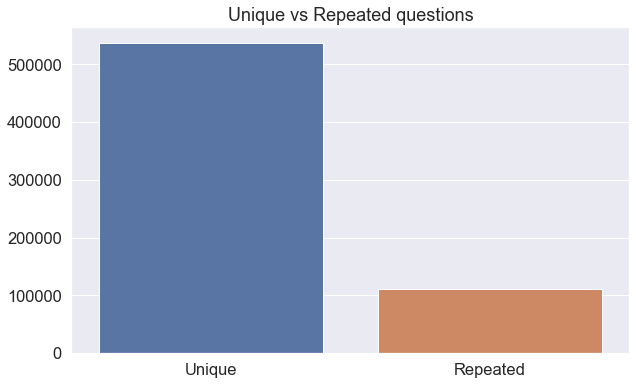

In [9]:
x = ["Unique" , "Repeated"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Unique vs Repeated questions")
sns.barplot(x = x, y = y)
plt.show()

In [10]:
# Checking whether there are any repeated pair of questions
pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print ("Number of duplicate questions", (pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


Maximum number of times a single question is repeated: 157



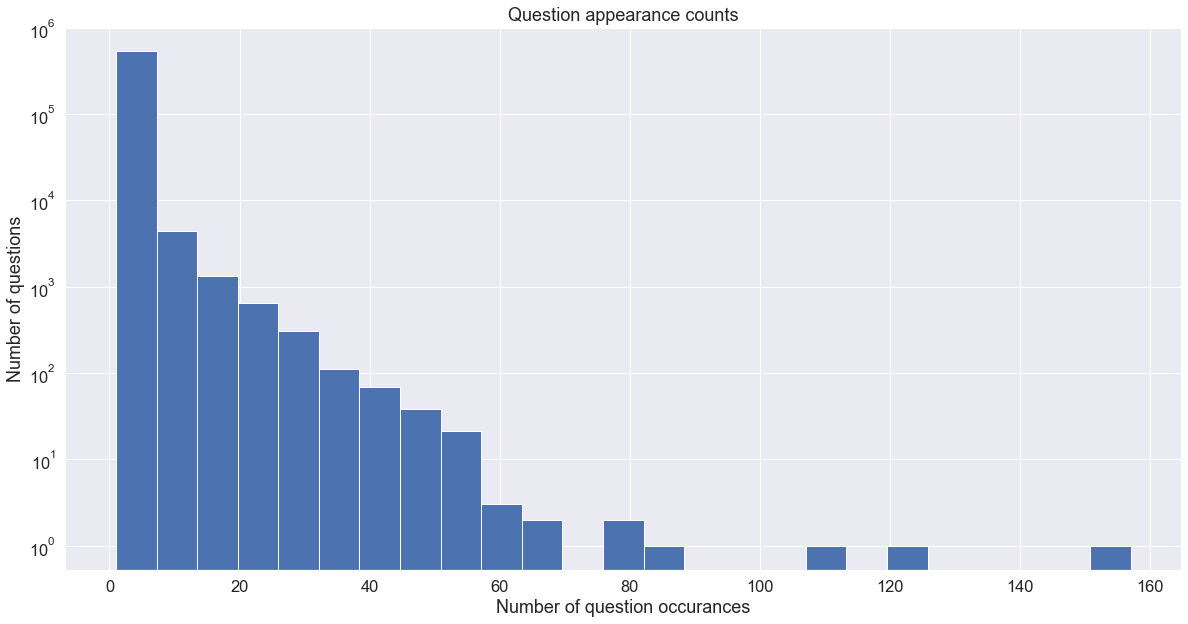

In [11]:
plt.figure(figsize=(20, 10))
plt.hist(qids.value_counts(), bins=25)
plt.yscale('log')
plt.title('Question appearance counts')
plt.xlabel('Number of question occurances')
plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts())))

In [12]:
df.dtypes

id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object

In [13]:
def check_na(df):
    strr = 0
    intt = 0
    for i in df:
        if type(i) == str:
            strr += 1
        else:
            intt += 1
            print(i)
    print('strings: ',  strr, 'else: ', intt)

In [14]:
df = df.dropna()
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0


In [15]:
check_na(df)

strings:  6 else:  0


In [16]:
# df['q1_char_num'] = df['question1'].apply(len)
# df['q2_char_num'] = df['question2'].apply(len)
# df['q1_q2_char_num_diff'] = df['q1_char_num'] - df['q2_char_num']
df['q1_word_num'] = df.question1.apply(lambda x: len(x))
df['q2_word_num'] = df.question2.apply(lambda x: len(x))
df['total_word_num'] = df['q1_word_num'] + df['q2_word_num']
df['differ_word_num'] = abs(df['q1_word_num'] - df['q2_word_num'])

In [17]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,q1_word_num,q2_word_num,total_word_num,differ_word_num
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,123,9
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,139,37


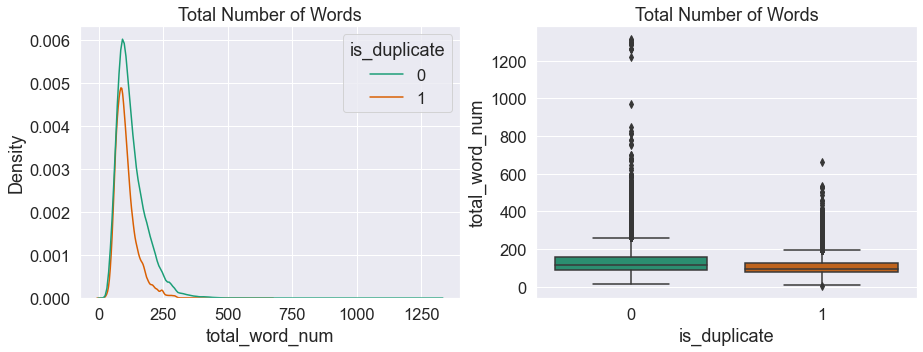

In [18]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('Total Number of Words')
sns.kdeplot(df['total_word_num'], hue=df.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Total Number of Words')
sns.boxplot(x=df.is_duplicate, y=df['total_word_num'], palette="Dark2", ax=ax[1])
plt.show()

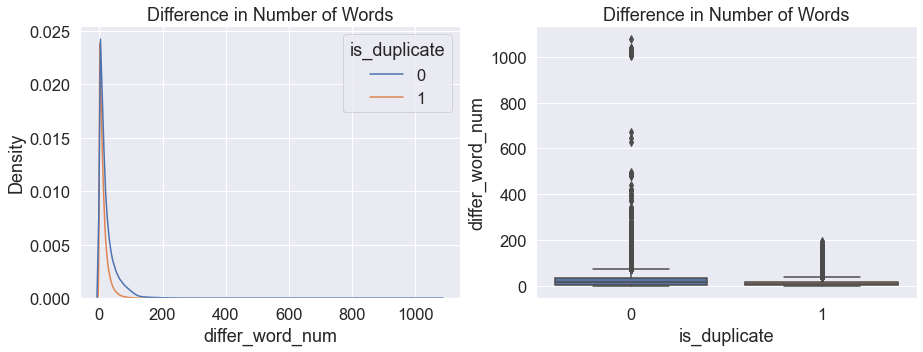

In [19]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('Difference in Number of Words')
sns.kdeplot(df['differ_word_num'], hue=df.is_duplicate, ax=ax[0])
ax[1].title.set_text('Difference in Number of Words')
sns.boxplot(x=df.is_duplicate, 
            y=df['differ_word_num'], 
            ax=ax[1])
plt.show()

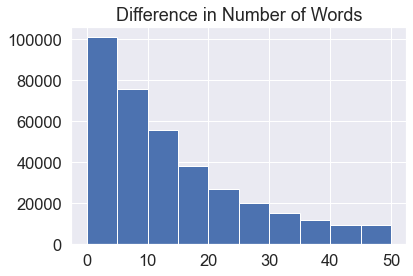

In [20]:
plt.hist(df['differ_word_num'], bins=[0,5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.title('Difference in Number of Words');

### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [21]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\benny\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:
# tokenize
from nltk.tokenize import word_tokenize
import string
df2 = df.copy()
# lowercase normalize
df2['question1'] = df2['question1'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df2['question2'] = df2['question2'].apply(lambda x: " ".join(x.lower() for x in x.split()))
# remove punctuation
df2['question1'] = df2['question1'].apply(lambda x: " ".join(x.translate(str.maketrans('','',string.punctuation)) for x in x.split()))
df2['question2'] = df2['question2'].apply(lambda x: " ".join(x.translate(str.maketrans('','',string.punctuation)) for x in x.split()))
# tokenize
df2['question1_tokenized'] = df2['question1'].apply(word_tokenize)
df2['question2_tokenized'] = df2['question2'].apply(word_tokenize)

In [23]:
df2.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,q1_word_num,q2_word_num,total_word_num,differ_word_num,question1_tokenized,question2_tokenized
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,66,57,123,9,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv..."
1,1,3,4,what is the story of kohinoor kohinoor diamond,what would happen if the indian government sto...,0,51,88,139,37,"[what, is, the, story, of, kohinoor, kohinoor,...","[what, would, happen, if, the, indian, governm..."


In [31]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\benny\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [32]:
# stopwords question1 and question2
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
df2['question1_stopwords'] = df2['question1_tokenized'].apply(lambda x: [i for i in x if i not in stop])
df2['question2_stopwords'] = df2['question2_tokenized'].apply(lambda x: [i for i in x if i not in stop])

In [34]:
df2.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,q1_word_num,q2_word_num,total_word_num,differ_word_num,question1_tokenized,question2_tokenized,question1_stopwords,question2_stopwords
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,66,57,123,9,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv...","[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]"
1,1,3,4,what is the story of kohinoor kohinoor diamond,what would happen if the indian government sto...,0,51,88,139,37,"[what, is, the, story, of, kohinoor, kohinoor,...","[what, would, happen, if, the, indian, governm...","[story, kohinoor, kohinoor, diamond]","[would, happen, indian, government, stole, koh..."


In [35]:
df3 = df2.copy()

In [36]:
df3['total_q1q2_unique_word_num'] = df3.apply(lambda x: len(set(x.question1.split()).union(set(x.question2.split()))) ,axis=1)
df3['total_nostop_len_diff'] = df3.apply(lambda x: abs(len(x.question1_stopwords) - len(x.question2_stopwords)), axis=1)

In [38]:
df3.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_word_num,q2_word_num,total_word_num,differ_word_num,question1_tokenized,question2_tokenized,question1_stopwords,question2_stopwords,total_q1q2_unique_word_num,total_nostop_len_diff
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,66,57,123,9,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv...","[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",12,1
1,1,3,4,what is the story of kohinoor kohinoor diamond,what would happen if the indian government sto...,0,51,88,139,37,"[what, is, the, story, of, kohinoor, kohinoor,...","[what, would, happen, if, the, indian, governm...","[story, kohinoor, kohinoor, diamond]","[would, happen, indian, government, stole, koh...",14,5
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,73,59,132,14,"[how, can, i, increase, the, speed, of, my, in...","[how, can, internet, speed, be, increased, by,...","[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]",20,1
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math2324math is divide...,0,50,65,115,15,"[why, am, i, mentally, very, lonely, how, can,...","[find, the, remainder, when, math2324math, is,...","[mentally, lonely, solve]","[find, remainder, math2324math, divided, 2423]",19,2
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0,76,39,115,37,"[which, one, dissolve, in, water, quikly, suga...","[which, fish, would, survive, in, salt, water]","[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]",16,5


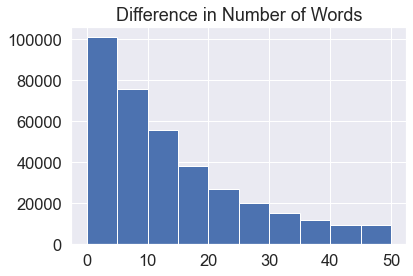

In [39]:
plt.hist(df3['differ_word_num'], bins=[0,5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.title('Difference in Number of Words');

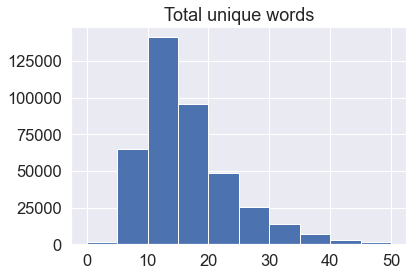

In [40]:
plt.hist(df3['total_q1q2_unique_word_num'], bins=[0,5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.title('Total unique words');

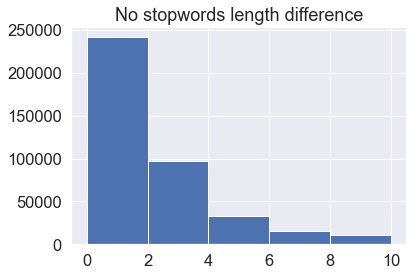

In [41]:
plt.hist(df3['total_nostop_len_diff'], bins=[0,2, 4, 6, 8, 10])
plt.title('No stopwords length difference');

### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

In [42]:
# tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf = TfidfVectorizer(max_df=0.95, 
                         min_df=2,
                         max_features=100,
                         stop_words='english')

In [43]:
df3.keys()

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'q1_word_num', 'q2_word_num', 'total_word_num', 'differ_word_num',
       'question1_tokenized', 'question2_tokenized', 'question1_stopwords',
       'question2_stopwords', 'total_q1q2_unique_word_num',
       'total_nostop_len_diff'],
      dtype='object')

In [44]:
train = df3[['is_duplicate', 
'q1_word_num', 
'q2_word_num', 
'total_word_num', 
'differ_word_num', 
'total_q1q2_unique_word_num', 
'total_nostop_len_diff']]

In [45]:
train

,is_duplicate,q1_word_num,q2_word_num,total_word_num,differ_word_num,total_q1q2_unique_word_num,total_nostop_len_diff
0,0,66,57,123,9,12,1
1,0,51,88,139,37,14,5
2,0,73,59,132,14,20,1
3,0,50,65,115,15,19,2
4,0,76,39,115,37,16,5
...,...,...,...,...,...,...,...
404285,0,85,79,164,6,14,0
404286,1,41,42,83,1,11,0
404287,0,17,17,34,0,6,0
404288,0,94,127,221,33,39,4


### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

In [46]:
def make_X_y(df):
    X = df.drop(['is_duplicate'], axis=1)
    y = df['is_duplicate']
    return X, y

In [47]:
# train_test_split
def train_test_split(X, y, test_size):
    from sklearn.model_selection import train_test_split
    """
    This just splits data to training and testing parts
    """
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

In [49]:
def naive_bayes(X_train, X_test, y_train, y_test):
    from sklearn.naive_bayes import MultinomialNB
    clf = MultinomialNB()
    clf.fit(X_train,y_train)
    ypred = clf.predict(X_test)
    from sklearn.metrics import confusion_matrix
    mat = confusion_matrix(y_test, ypred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    from sklearn.metrics import accuracy_score
    print('accuracy score: ', accuracy_score(y_test, ypred))
    from sklearn.metrics import classification_report
    print('classification report: ', classification_report(y_test, ypred))

First

In [50]:
X, y = make_X_y(train)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

accuracy score:  0.557199040292859
classification report:                precision    recall  f1-score   support

           0       0.72      0.49      0.58     51026
           1       0.44      0.67      0.53     29832

    accuracy                           0.56     80858
   macro avg       0.58      0.58      0.56     80858
weighted avg       0.61      0.56      0.56     80858



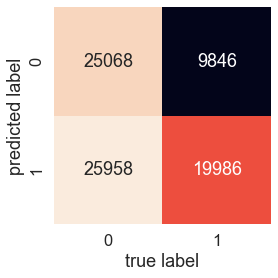

In [51]:
# naive bayes
naive_bayes(X_train, X_test, y_train, y_test)

In [52]:
# logistic regression
def logistic_regression(X_train, X_test, y_train, y_test):
    from sklearn.linear_model import LogisticRegression
    clf = LogisticRegression()
    clf.fit(X_train,y_train)
    ypred = clf.predict(X_test)
    from sklearn.metrics import confusion_matrix
    mat = confusion_matrix(y_test, ypred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    from sklearn.metrics import accuracy_score
    print('accuracy score: ', accuracy_score(y_test, ypred))
    from sklearn.metrics import classification_report
    print('classification report: ', classification_report(y_test, ypred))

accuracy score:  0.6302283014667689
classification report:                precision    recall  f1-score   support

           0       0.67      0.81      0.73     51026
           1       0.50      0.33      0.40     29832

    accuracy                           0.63     80858
   macro avg       0.59      0.57      0.57     80858
weighted avg       0.61      0.63      0.61     80858



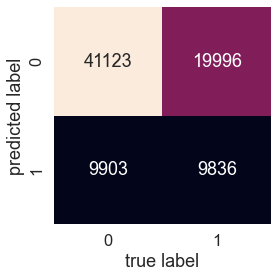

In [53]:
logistic_regression(X_train, X_test, y_train, y_test)

In [55]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [56]:
def XGboost(X_train, X_test, y_train, y_test):
    from xgboost import XGBClassifier
    clf = XGBClassifier()
    clf.fit(X_train,y_train)
    ypred = clf.predict(X_test)
    from sklearn.metrics import confusion_matrix
    mat = confusion_matrix(y_test, ypred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    from sklearn.metrics import accuracy_score
    print('accuracy score: ', accuracy_score(y_test, ypred))
    from sklearn.metrics import classification_report
    print('classification report: ', classification_report(y_test, ypred))

accuracy score:  0.6745281852135843
classification report:                precision    recall  f1-score   support

           0       0.73      0.77      0.75     51026
           1       0.57      0.51      0.54     29832

    accuracy                           0.67     80858
   macro avg       0.65      0.64      0.64     80858
weighted avg       0.67      0.67      0.67     80858



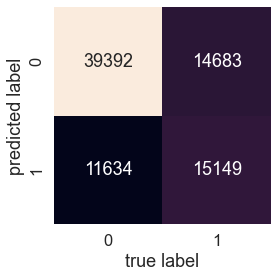

In [57]:
XGboost(X_train, X_test, y_train, y_test)

In [58]:
# gridsearch function
def grid_search(X_train, X_test, y_train, y_test):
    from sklearn.model_selection import GridSearchCV
    from sklearn.ensemble import RandomForestClassifier
    from xgboost import XGBClassifier
    from sklearn.svm import SVC
    from sklearn.neighbors import KNeighborsClassifier
    parameters = {'n_estimators':[75], 'max_depth':[10, 20, 30], 'max_features':[4]}
    svc = SVC() # pick
    knn = KNeighborsClassifier() # pick
    rf = RandomForestClassifier() # pick
    xgb = XGBClassifier() # pick
    grid_search = GridSearchCV(rf, parameters, cv=5, scoring='accuracy') # njobs=-1
    grid_search.fit(X_train, y_train)
    print("Best parameters set found on development set:")
    print()
    print(grid_search.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, grid_search.predict(X_test)
    from sklearn.metrics import classification_report
    print(classification_report(y_true, y_pred))
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import accuracy_score
    print("Accuracy Score: \n")
    print(accuracy_score(y_true, y_pred))
    print("Confusion Matrix: \n")
    from sklearn.metrics import confusion_matrix
    mat = confusion_matrix(y_true, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');

Best parameters set found on development set:

{'max_depth': 10, 'max_features': 4, 'n_estimators': 75}

Grid scores on development set:

0.673 (+/-0.003) for {'max_depth': 10, 'max_features': 4, 'n_estimators': 75}
0.652 (+/-0.005) for {'max_depth': 20, 'max_features': 4, 'n_estimators': 75}
0.640 (+/-0.004) for {'max_depth': 30, 'max_features': 4, 'n_estimators': 75}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.73      0.77      0.75     51026
           1       0.56      0.51      0.53     29832

    accuracy                           0.67     80858
   macro avg       0.65      0.64      0.64     80858
weighted avg       0.67      0.67      0.67     80858

Accuracy Score: 

0.6727596527245294
Confusion Matrix: 



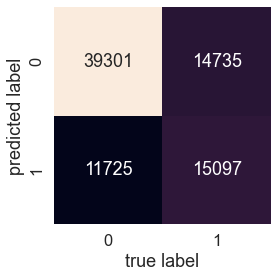

In [59]:
# grid search 10 minutes
grid_search(X_train, X_test, y_train, y_test)